In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
# defining function for plotting correlation heatmap
def plot_heatmap(correlation, title):
    plt.figure(figsize=(15, 8))
    ax = sns.heatmap(correlation,annot=True,fmt='.3f',linewidths=0.3,annot_kws={"size": 18})
    plt.xticks(fontsize=12) 
    plt.yticks(fontsize=12) 
    plt.title(title, fontsize=20)
    ax.figure.axes[-1].tick_params(labelsize=18) # To increase fontsize of colorbar ticks
    #lim = len(correlation.columns)
    #ax.set_ylim([0,lim]) # to make the map display correctly without trimming the edges
    plt.show()
    return

In [3]:
# importing the dataset
dataset = pd.read_csv('covid_train.csv')

In [4]:
dataset.head(5)

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,50s,MALE,NO KNOWN EPI LINK,Oakville,NaN,43.413997,-79.744796,Resolved
1,20s,FEMALE,CC,Guelph,NaN,43.524881,-80.233743,Not Resolved
2,90s,FEMALE,OB,Barrie,Yes,44.410713,-79.686306,Resolved
3,20s,FEMALE,MISSING INFORMATION,Toronto,NaN,43.656591,-79.379358,Resolved
4,90s,FEMALE,OB,Ottawa,Yes,45.345665,-75.763912,Fatal


## Data Cleaning

In [5]:
# checking for missing values in columns
for column in dataset.columns:
    print(column, "-", dataset[column].isna().sum())

Age_Group - 6
Client_Gender - 0
Case_AcquisitionInfo - 0
Reporting_PHU_City - 0
Outbreak_Related - 9020
Reporting_PHU_Latitude - 0
Reporting_PHU_Longitude - 0
Outcome1 - 0


In [6]:
# filling missing values in outbreak related with NO
dataset["Outbreak_Related"].fillna("No", inplace=True)

# drop missing columns in Age_Group
dataset.dropna(axis=0, inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [7]:
# grouping features accourding to their data types
cats = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Outbreak_Related']
nums = ['Reporting_PHU_Latitude', 'Reporting_PHU_Longitude']
ords = ['Age_Group']
target = ['Outcome1']

In [8]:
dataset['Age_Group'].replace(["<20", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"],[0,1,2,3,4,5,6,7,8], inplace = True)

# Label encoding the outcomes
dataset['Outcome1'].replace(["Resolved", "Not Resolved", "Fatal"],[0,1,2], inplace = True)

dataset.head()

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,4,MALE,NO KNOWN EPI LINK,Oakville,No,43.413997,-79.744796,0
1,1,FEMALE,CC,Guelph,No,43.524881,-80.233743,1
2,8,FEMALE,OB,Barrie,Yes,44.410713,-79.686306,0
3,1,FEMALE,MISSING INFORMATION,Toronto,No,43.656591,-79.379358,0
4,8,FEMALE,OB,Ottawa,Yes,45.345665,-75.763912,2


In [9]:
# create a copy of dataset
data = dataset.copy()

## Data Preparation

##### One Hot Encoding the categorical features

In [10]:
df = pd.get_dummies(dataset.iloc[:,:-1], columns = cats)
df["Outcome1"] = dataset["Outcome1"]
dataset = df

dataset.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_FEMALE,Client_Gender_GENDER DIVERSE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,...,Reporting_PHU_City_Thorold,Reporting_PHU_City_Thunder Bay,Reporting_PHU_City_Timmins,Reporting_PHU_City_Toronto,Reporting_PHU_City_Waterloo,Reporting_PHU_City_Whitby,Reporting_PHU_City_Windsor,Outbreak_Related_No,Outbreak_Related_Yes,Outcome1
0,4,43.413997,-79.744796,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,43.524881,-80.233743,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2,8,44.410713,-79.686306,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,43.656591,-79.379358,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,8,45.345665,-75.763912,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2


In [11]:
# Separating the dataset into matrix of features and target'
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [12]:
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=0)

## Building the Base Model

In [13]:
%%time
from sklearn.model_selection import GridSearchCV

# Fitting the Classification Model
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

nb_params = [{'var_smoothing':[1e-10, 1e-9, 1e-5, 1e-3, 1e-1]}]
nb_grid = GridSearchCV(nb, nb_params, cv=10)
nb_grid.fit(X_train_1, y_train_1)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

Wall time: 678 ms


GaussianNB(var_smoothing=0.1)

In [14]:
nb_average_score

array([0.37875625, 0.4047738 , 0.55860423, 0.6085387 , 0.6577997 ])

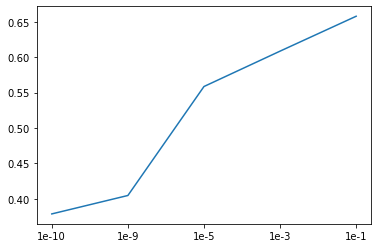

In [15]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [16]:
%%time
# Building model with optimal parameters
nb_1 = GaussianNB(var_smoothing=0.1)
nb_1.fit(X_train_1, y_train_1)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train_1, nb_1.predict(X_train_1)), 2))
print("F1_score: ", round(f1_score(y_train_1, nb_1.predict(X_train_1), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train_1, nb_1.predict_proba(X_train_1), average = "macro", multi_class = "ovo"), 2))

Training Set Evaluation
Accuracy:  65.82
F1_score:  0.64
AUC:  0.82
Wall time: 85 ms


In [17]:
# Evaluating the model on the test set
nb_pred = nb_1.predict(X_test_1)

print("Test Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_test_1, nb_pred), 2))
print("F1_score: ", round(f1_score(y_test_1, nb_pred, average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_test_1, nb_1.predict_proba(X_test_1), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  65.44
F1_score:  0.64
AUC:  0.82


## <span style="color:blue"> Notes About Smoothing Parameter </span>

1e-1 is the best smoothing parameter with an accuracy of 65.76%. 
Accuracy increases almost linearly with smoothing variable.

The smoothing variable represents the portion of the largest variance of all features that is added to variances for calculation stability.

A Gaussian curve can serve as a "low pass" filter, allowing only the samples close to its mean to "pass." In the context of Naive Bayes, assuming a Gaussian distribution is essentially giving more weights to the samples closer to the distribution mean. This might filter out some values that we want to "pass".

The variable, var_smoothing, artificially adds a user-defined value to the distribution's variance (whose default value is derived from the training data set). This essentially widens (or "smooths") the curve and accounts for more samples that are further away from the distribution mean.

Tuning this parameter, will also modify the variance in a way that will give the best accuracy.


### Improving Model Computation Time

### <span style="color:blue"> Method 1: Dropping the Reporting_PHU_City column </span>

The Reporting_PHU_City column is a categorical column with 34 distinct values this means that after one-hot encoding, it adds 34 columns to the data thus, making it computationally expensive.

Considering its low correlation with the outcome, we will deal with this by removing the feature from the matrix of features. This reduces the columns in the matrix of features from 49 to 15 


In [18]:
# removing the Reporting_PHU_City column
dataset2 =  data[['Age_Group', 'Client_Gender', 'Case_AcquisitionInfo',
                    'Outbreak_Related', 'Reporting_PHU_Latitude',
                   'Reporting_PHU_Longitude', 'Outcome1']]

df = pd.get_dummies(dataset2.iloc[:,:-1], columns = ['Client_Gender','Case_AcquisitionInfo','Outbreak_Related'])
df["Outcome1"] = dataset2["Outcome1"]
dataset2 = df

dataset2.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_FEMALE,Client_Gender_GENDER DIVERSE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,Case_AcquisitionInfo_CC,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL,Case_AcquisitionInfo_UNSPECIFIED EPI LINK,Outbreak_Related_No,Outbreak_Related_Yes,Outcome1
0,4,43.413997,-79.744796,0,0,1,0,0,0,1,0,0,0,1,0,0
1,1,43.524881,-80.233743,1,0,0,0,1,0,0,0,0,0,1,0,1
2,8,44.410713,-79.686306,1,0,0,0,0,0,0,1,0,0,0,1,0
3,1,43.656591,-79.379358,1,0,0,0,0,1,0,0,0,0,1,0,0
4,8,45.345665,-75.763912,1,0,0,0,0,0,0,1,0,0,0,1,2


In [19]:
# Separating the dataset into matrix of features and target'
X = dataset2.iloc[:,:-1].values
y = dataset2.iloc[:,-1].values

In [20]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
%%time

# Fitting the Classification Model
nb_grid.fit(X_train_2, y_train_2)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

Wall time: 237 ms


GaussianNB(var_smoothing=0.1)

In [22]:
nb_average_score

array([0.55717183, 0.55397254, 0.55767915, 0.60769759, 0.6569571 ])

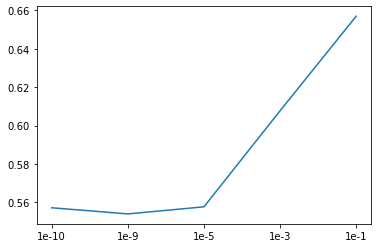

In [23]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [24]:
%%time
# Building model with optimal parameters
nb_2 = GaussianNB(var_smoothing=0.1)
nb_2.fit(X_train_2, y_train_2)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train_2, nb_2.predict(X_train_2)), 2))
print("F1_score: ", round(f1_score(y_train_2, nb_2.predict(X_train_2), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train_2, nb_2.predict_proba(X_train_2), average = "macro", multi_class = "ovo"), 2))

Training Set Evaluation
Accuracy:  65.68
F1_score:  0.64
AUC:  0.82
Wall time: 43 ms


In [25]:
# Evaluating the model on the test set
nb_pred = nb_2.predict(X_test_2)

print("Test Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_test_2, nb_pred), 2))
print("F1_score: ", round(f1_score(y_test_2, nb_pred, average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_test_2, nb_2.predict_proba(X_test_2), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  65.34
F1_score:  0.63
AUC:  0.82


### <span style="color:blue"> Method 2: Aggregating categories in the columns </span>

In the Client_Gender feature, UNSPECIFIED and GENDER DIVERSE have very low counts compared to the rest and they can both be grouped into one category OTHERS.

In the Case_AcquisitionInfo feature, TRAVEL and UNSPECIFIED EPI LINK have very low counts compared to the rest and they can both be grouped into one category OTHERS.

In the Reporting_PHU_City feature, there are 34 distince categories. Rather than dropping the entire feature, the categories can be grouped by their counts.
City_Class1 = > 500
City_Class2 = 75 to 500
City_Class3 = < 75

In [26]:
# inspecting the unique values in categorical columns and their frequencies
dataset3 = data.copy()

In [27]:
dataset3["Client_Gender"].replace(['UNSPECIFIED', 'GENDER DIVERSE'], 'OTHER', inplace = True)
dataset3["Case_AcquisitionInfo"].replace(['TRAVEL', 'UNSPECIFIED EPI LINK'], 'OTHER', inplace = True)

In [28]:
City_Class1 = list((dataset3['Reporting_PHU_City'].value_counts()[dataset3['Reporting_PHU_City'].value_counts() > 500]).index)

In [29]:
City_Class2 = list((dataset3['Reporting_PHU_City'].value_counts()[(dataset3['Reporting_PHU_City'].value_counts() <= 500) & (dataset3['Reporting_PHU_City'].value_counts() > 75)]).index)

In [30]:
City_Class3 = list((dataset3['Reporting_PHU_City'].value_counts()[dataset3['Reporting_PHU_City'].value_counts() <= 75]).index)

In [31]:
dataset3["Reporting_PHU_City"].replace(City_Class1, 1, inplace = True)
dataset3["Reporting_PHU_City"].replace(City_Class2, 2, inplace = True)
dataset3["Reporting_PHU_City"].replace(City_Class3, 3, inplace = True)

In [32]:
df = pd.get_dummies(dataset3.iloc[:,:-1], drop_first=True, columns = cats)
df["Outcome1"] = dataset3["Outcome1"]
dataset3 = df

dataset3.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_MALE,Client_Gender_OTHER,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_OTHER,Reporting_PHU_City_2,Reporting_PHU_City_3,Outbreak_Related_Yes,Outcome1
0,4,43.413997,-79.744796,1,0,0,1,0,0,1,0,0,0
1,1,43.524881,-80.233743,0,0,0,0,0,0,1,0,0,1
2,8,44.410713,-79.686306,0,0,0,0,1,0,1,0,1,0
3,1,43.656591,-79.379358,0,0,1,0,0,0,0,0,0,0
4,8,45.345665,-75.763912,0,0,0,0,1,0,0,0,1,2


In [33]:
# Separating the dataset into matrix of features and target'
X = dataset3.iloc[:,:-1].values
y = dataset3.iloc[:,-1].values

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:
%%time

# Fitting the Classification Model
nb_grid.fit(X_train, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

Wall time: 311 ms


GaussianNB(var_smoothing=0.1)

In [36]:
nb_average_score

array([0.60643595, 0.60643595, 0.60643588, 0.61148809, 0.65013757])

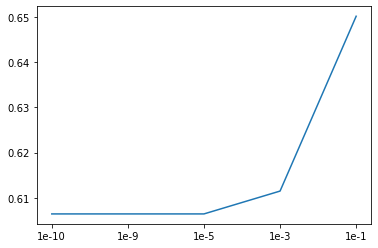

In [37]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [38]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.1)
nb.fit(X_train, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_train)), 2))
print("F1_score: ", round(f1_score(y_train, nb.predict(X_train), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train, nb.predict_proba(X_train), average = "macro", multi_class = "ovo"), 2))

Training Set Evaluation
Accuracy:  64.9
F1_score:  0.62
AUC:  0.82
Wall time: 43 ms


In [39]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_test)

print("Test Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_test, nb_pred), 2))
print("F1_score: ", round(f1_score(y_test, nb_pred, average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_test, nb.predict_proba(X_test), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  64.8
F1_score:  0.62
AUC:  0.82


## Impact of Feature Selection and Engineering

##### Using all features
| | Accuracy | F1 Score | AUC|
| --- | --- | --- |--- |
| Training Set | 65.82 | 0.64 | 0.82 |
| Test Set | 65.44 | 0.64 | 0.82 |

##### Dropping the City column
| | Accuracy | F1 Score | AUC|
| --- | --- | --- |--- |
| Training Set | 65.68 | 0.64 | 0.82 |
| Test Set | 65.34 | 0.63 | 0.82 |

##### Aggregating the categories of the features
| | Accuracy | F1 Score | AUC|
| --- | --- | --- |--- |
| Training Set | 64.9 | 0.62 | 0.82 |
| Test Set | 64.8 | 0.62 | 0.82 |

#### Observations
There in no much difference in performance between adding the city feature and dropping the city feature. So we can drop the city feature to improve computation performance.


### Improving the model by feature scaling

##### Standard Scaler

In [40]:
X_scaler = StandardScaler()
X_SS = X_scaler.fit_transform(X_train)
X_SS_test = X_scaler.transform(X_test)
nb_grid.fit(X_SS, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

GaussianNB(var_smoothing=1e-10)

In [41]:
nb_average_score

array([0.60643595, 0.60643595, 0.60643595, 0.60635178, 0.60180512])

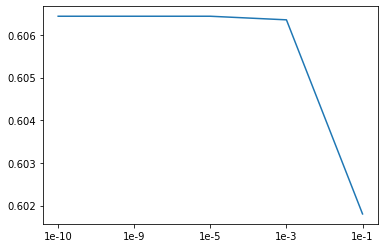

In [42]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [43]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=1e-10)
nb.fit(X_SS, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_SS)), 2))

Training Set Evaluation
Accuracy:  60.99
Wall time: 12 ms


In [44]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_SS_test)
accuracy_1 = round(100 * accuracy_score(y_test, nb_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  59.99


##### MinMax Scaler

In [45]:
X_scaler = MinMaxScaler()
X_MMS = X_scaler.fit_transform(X_train)
X_MMS_test = X_scaler.transform(X_test)
nb_grid.fit(X_MMS, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

GaussianNB(var_smoothing=0.1)

In [46]:
nb_average_score

array([0.60643595, 0.60643595, 0.60643595, 0.60601494, 0.60685704])

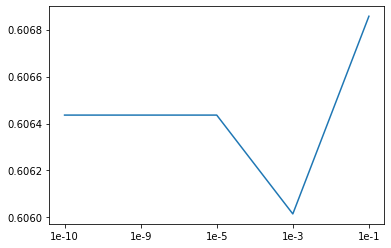

In [47]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [48]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=0.1)
nb.fit(X_MMS, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_MMS)), 2))

Training Set Evaluation
Accuracy:  61.04
Wall time: 12 ms


In [49]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_MMS_test)
accuracy_1 = round(100 * accuracy_score(y_test, nb_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  60.19


##### Robust Scaler

In [50]:
X_scaler = RobustScaler()
X_RS = X_scaler.fit_transform(X_train)
X_RS_test = X_scaler.transform(X_test)
nb_grid.fit(X_RS, y_train)
nb_average_score = nb_grid.cv_results_['mean_test_score'].astype(float)
result = nb_grid.cv_results_
nb_grid.best_estimator_

GaussianNB(var_smoothing=1e-05)

In [51]:
nb_average_score

array([0.60643595, 0.60643595, 0.61165644, 0.52905352, 0.33310882])

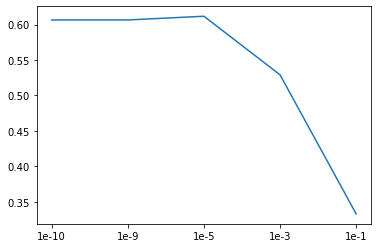

In [52]:
plt.figure()
sns.lineplot(x=["1e-10", "1e-9", "1e-5", "1e-3", "1e-1"], y=nb_average_score)
plt.show()

In [53]:
%%time
# Building model with optimal parameters
nb = GaussianNB(var_smoothing=1e-05)
nb.fit(X_RS, y_train)

print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, nb.predict(X_RS)), 2))

Training Set Evaluation
Accuracy:  61.27
Wall time: 18 ms


In [54]:
# Evaluating the model on the test set
nb_pred = nb.predict(X_RS_test)
accuracy_1 = round(100 * accuracy_score(y_test, nb_pred), 2)
print("Test Set Evaluation")
print("Accuracy: ", accuracy_1)

Test Set Evaluation
Accuracy:  60.59


The Naive Bayes classifier performs better without feature scalling

### <span style="color:blue"> Notes About Feature Scaling on Naive Bayes </span>

Effects of Scaling on Training Set and Test set accuracy

| Scaling Method | Train Accuracy | Test Accuracy | 
| --- | --- | --- |
| Standard Scaler | 60.99 | 59.99 |
| MinMax Scaler | 61.04 | 60.19 | 
| Robust Scaler | 61.27 | 60.59 | 
| No Scaler | 64.9 | 64.8 | 


The Naive Bayes classifier performs better without feature scaling. Naive Bayes is not very sensitive to distance between values like KNN, so we did not expect much improvement from Feature Scaling.

## <span style="color:blue">CM6 (Covid Dataset) </span>

In [55]:
print("Feature Means per class: \n", nb_2.theta_)

Feature Means per class: 
 [[ 2.72566151e+00  4.37274733e+01 -7.95909554e+01  4.96505242e-01
   2.49625562e-04  4.97254119e-01  5.99101348e-03  4.40339491e-01
   1.59760359e-01  2.05941088e-01  1.75736395e-01  1.72241638e-02
   9.98502247e-04  7.90314528e-01  2.09685472e-01]
 [ 2.92826253e+00  4.37725211e+01 -7.96265344e+01  4.99872806e-01
   2.54388196e-04  4.90714831e-01  9.15797507e-03  3.14932587e-01
   3.56652251e-01  1.32790639e-01  1.85703383e-01  9.92113966e-03
   0.00000000e+00  7.83770033e-01  2.16229967e-01]
 [ 6.82482864e+00  4.37284837e+01 -7.94626338e+01  5.18151815e-01
   0.00000000e+00  4.74739782e-01  7.10840315e-03  7.64153338e-02
   7.53998477e-02  9.92637725e-02  7.36481340e-01  1.24397055e-02
   0.00000000e+00  2.37877634e-01  7.62122366e-01]]


In [56]:
print("Feature Variance per class: \n", nb_2.sigma_)

Feature Variance per class: 
 [[4.82678204 1.19182136 3.06681906 0.93460757 0.68486935 0.93461225
  0.69057491 0.93106041 0.81885677 0.84814914 0.8294729  0.70154728
  0.68561729 0.85033726 0.85033726]
 [5.09463506 1.31843911 3.15977427 0.93461977 0.68487411 0.93453357
  0.69369389 0.90036984 0.91407121 0.79977707 0.83583742 0.6944425
  0.68461979 0.85409435 0.85409435]
 [2.00453138 1.22660619 3.25730642 0.9342903  0.68461979 0.93398171
  0.69167766 0.75519582 0.7543345  0.77403026 0.87869636 0.69690475
  0.68461979 0.86591165 0.86591165]]


In [57]:
print("Class Priors: \n", nb_2.class_prior_)

Class Priors: 
 [0.33731896 0.3310037  0.33167733]


#####  <span style="color:blue"> Learned Parameters and Naive Bayes </span>
The Feature Means and Variances best describe the classifier

##### <span style="color:blue">Perfomance of Decision Tree vs Naive Bayes</span>

|Accuracy|Decision Tree | Naive Bayes | 
| --- | --- | --- |
| Training  Accuracy | 66.14 | 65.68 |
| Test Accuracy | 65.91 | 65.34 | 
| **Wall Time | 364ms | 4.59ms |

Naive Bayes seems to perform almost as well as Decision Tree and is much faster than Decision Tree in computation time.

In [58]:
from sklearn.inspection import permutation_importance
r = permutation_importance(nb_2, X_train_2, y_train_2, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{dataset2.columns[i]:<8}  "
              f" Mean: + {r.importances_mean[i]:.3f}  "
               f" STD: +/- {r.importances_std[i]:.3f}")

Age_Group   Mean: + 0.263   STD: +/- 0.004
Case_AcquisitionInfo_MISSING INFORMATION   Mean: + 0.046   STD: +/- 0.002
Case_AcquisitionInfo_CC   Mean: + 0.012   STD: +/- 0.001
Case_AcquisitionInfo_NO KNOWN EPI LINK   Mean: + 0.006   STD: +/- 0.001


#### <span style="color:blue"> Relation to Decision Tree Splitting Rules </span>
The most important features learned by the Naive Bayes Classifier; Age Group and Case_AcquisitionInfo were also used in the splitting rules of the Decision Tree. 
